In [1]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Step 2: Load April 2024 Parquet data
df = pd.read_parquet(r"C:\Users\Abhinav\Documents\NMIMS\SEM 6\PA\green_tripdata_2024-04.parquet")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56471 entries, 0 to 56470
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               56471 non-null  int32         
 1   lpep_pickup_datetime   56471 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  56471 non-null  datetime64[ns]
 3   store_and_fwd_flag     54483 non-null  object        
 4   RatecodeID             54483 non-null  float64       
 5   PULocationID           56471 non-null  int32         
 6   DOLocationID           56471 non-null  int32         
 7   passenger_count        54483 non-null  float64       
 8   trip_distance          56471 non-null  float64       
 9   fare_amount            56471 non-null  float64       
 10  extra                  56471 non-null  float64       
 11  mta_tax                56471 non-null  float64       
 12  tip_amount             56471 non-null  float64       
 13  t

In [3]:
# Step 3: Drop ehail_fee column
df.drop(columns=["ehail_fee"], inplace=True, errors='ignore')

In [4]:
# Step 4: Compute trip duration in minutes
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

In [5]:
# Step 5: Extract weekday and hour
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour

print("Weekday Counts:\n", df['weekday'].value_counts())
print("Hour Counts:\n", df['hourofday'].value_counts())

Weekday Counts:
 weekday
Tuesday      9731
Monday       9208
Thursday     8469
Wednesday    8067
Friday       7812
Saturday     7042
Sunday       6142
Name: count, dtype: int64
Hour Counts:
 hourofday
17    4635
18    4545
16    4219
15    3967
14    3513
19    3489
12    3150
9     3072
10    3019
13    3014
11    2934
20    2703
8     2476
21    2291
22    2040
7     1845
23    1536
0     1085
6      718
1      709
2      545
3      347
4      310
5      309
Name: count, dtype: int64


In [6]:
# Step 6: Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

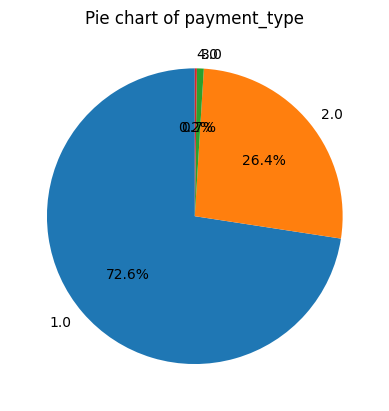

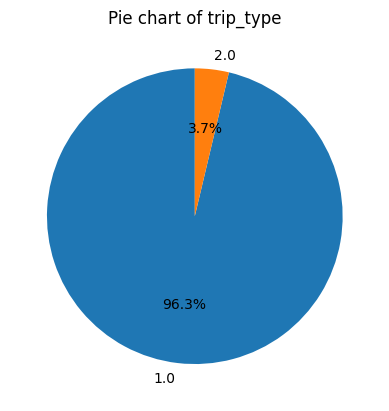

In [7]:
# Step 7: Pie Charts
for col in ['payment_type', 'trip_type']:
    if col in df.columns:
        df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
        plt.title(f'Pie chart of {col}')
        plt.ylabel('')
        plt.show()

In [8]:
# Step 8: GroupBy Analysis
print("Average total_amount by weekday:\n", df.groupby('weekday')['total_amount'].mean())
print("Average total_amount by payment_type:\n", df.groupby('payment_type')['total_amount'].mean())
print("Average tip_amount by weekday:\n", df.groupby('weekday')['tip_amount'].mean())
print("Average tip_amount by payment_type:\n", df.groupby('payment_type')['tip_amount'].mean())

Average total_amount by weekday:
 weekday
Friday       23.245685
Monday       23.246048
Saturday     23.911488
Sunday       24.012317
Thursday     23.379406
Tuesday      23.097789
Wednesday    22.944717
Name: total_amount, dtype: float64
Average total_amount by payment_type:
 payment_type
1.0    24.765138
2.0    20.276277
3.0     2.875972
4.0     2.415938
Name: total_amount, dtype: float64
Average tip_amount by weekday:
 weekday
Friday       2.464187
Monday       2.392093
Saturday     2.575287
Sunday       2.704757
Thursday     2.545321
Tuesday      2.481036
Wednesday    2.541243
Name: tip_amount, dtype: float64
Average tip_amount by payment_type:
 payment_type
1.0    3.470061
2.0    0.000000
3.0    0.000000
4.0    0.000000
Name: tip_amount, dtype: float64


In [9]:
# Step 9: ANOVA Tests
anova_trip = f_oneway(*[x['total_amount'].dropna() for _, x in df.groupby('trip_type') if len(x) > 1])
anova_weekday = f_oneway(*[x['total_amount'].dropna() for _, x in df.groupby('weekday') if len(x) > 1])
print("ANOVA Trip Type p-value:", anova_trip.pvalue)
print("ANOVA Weekday p-value:", anova_weekday.pvalue)

ANOVA Trip Type p-value: 0.0
ANOVA Weekday p-value: 0.0006603049719845776


In [10]:
# Step 10: Chi-square test between trip_type and payment_type
if 'trip_type' in df.columns and 'payment_type' in df.columns:
    ct = pd.crosstab(df['trip_type'], df['payment_type'])
    chi2_stat, p_val, dof, ex = chi2_contingency(ct)
    print("Chi-Square p-value:", p_val)

Chi-Square p-value: 1.4074992344868895e-24


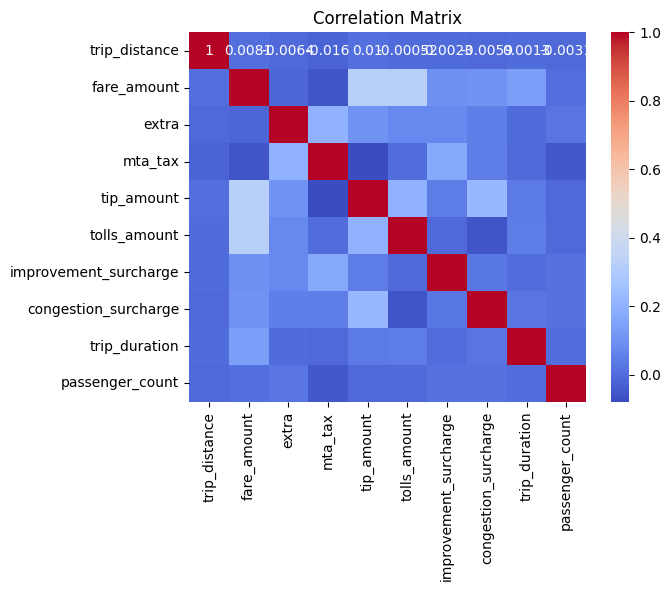

In [11]:
# Step 11: Correlation Matrix
num_cols = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
            'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
            'trip_duration', 'passenger_count']

sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Step 12: Dummy Encoding
obj_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday']
df = pd.get_dummies(df, columns=[col for col in obj_cols if col in df.columns], drop_first=True)

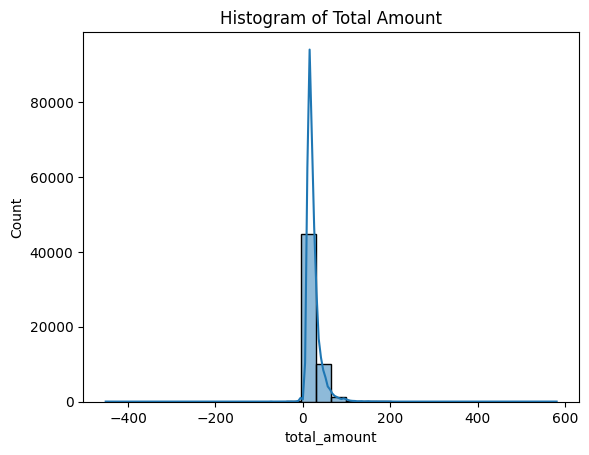

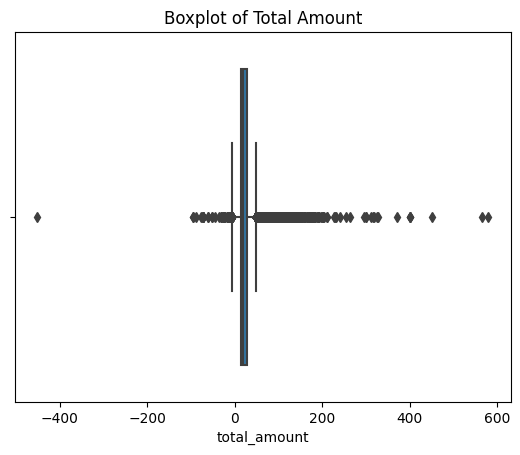

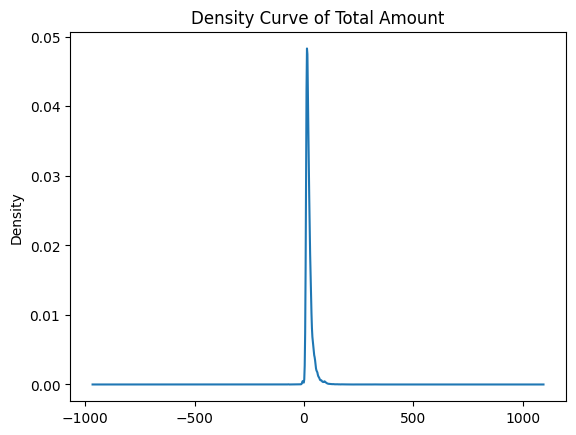

In [14]:
# Step 13: Visuals of Target Variable
sns.histplot(df['total_amount'], bins=30, kde=True)
plt.title("Histogram of Total Amount")
plt.show()

sns.boxplot(x=df['total_amount'])
plt.title("Boxplot of Total Amount")
plt.show()

df['total_amount'].plot.density()
plt.title("Density Curve of Total Amount")
plt.show()

In [15]:
# Step 14: Regression Models
drop_cols = ['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime']
X = df.drop(columns=[col for col in drop_cols if col in df.columns])
y = df['total_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multiple Linear Regression
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))

# Decision Tree
dt = DecisionTreeRegressor().fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree R²:", r2_score(y_test, y_pred_dt))

# Random Forest
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting R²:", r2_score(y_test, y_pred_gb))

Linear Regression R²: 0.9993788595400431
Decision Tree R²: 0.9570946218382874
Random Forest R²: 0.9564936745163106
Gradient Boosting R²: 0.9616712462829301
